In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from arch import arch_model
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

from data.stock_data import StockData

In [282]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()

# Drop all the rows where Log Return is exactly 0
sp500 = sp500[sp500['Log Return'] != 0]
sp500 = sp500.dropna()
sp500

# Make the sp500 be on a weekly frequency instead of daily
sp500 = sp500.resample('W').sum()
sp500.to_csv('data/sp500_weekly.csv')


[*********************100%***********************]  1 of 1 completed


In [283]:
sp500

,Log Return,Squared Return
Date,,
2006-01-08,1.303720,1.009653
2006-01-15,0.167896,0.665918
2006-01-22,-2.049422,4.014040
2006-01-29,1.746854,1.239267
2006-02-05,-1.545704,1.323481
...,...,...
2022-12-04,1.125743,11.759279
2022-12-11,-3.430731,6.504358
2022-12-18,-2.106730,10.530129


In [284]:
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
0,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
1,2006-02,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
2,2006-03,4.515,0.338,0.006086,0.085002,3.362649,-0.020833
3,2006-04,4.650,0.419,-0.002866,0.078793,3.545735,0.000000
4,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667,-0.021277
...,...,...,...,...,...,...,...
206,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974,-0.027778
207,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320,-0.028571
208,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609,0.088235
209,2023-06,5.153,-1.334,0.004591,0.037450,2.969178,-0.027027


In [285]:
# Calculate the monthly RV
sp500['YearMonth'] = sp500.index.to_period('M')
monthly_sum = sp500.groupby('YearMonth')['Squared Return'].transform('sum')
sp500['RV'] = monthly_sum

,Log Return,Squared Return,YearMonth,RV
Date,,,,
2006-01-08,1.303720,1.009653,2006-01,6.928878
2006-01-15,0.167896,0.665918,2006-01,6.928878
2006-01-22,-2.049422,4.014040,2006-01,6.928878
2006-01-29,1.746854,1.239267,2006-01,6.928878
2006-02-05,-1.545704,1.323481,2006-02,5.433545
...,...,...,...,...
2022-12-04,1.125743,11.759279,2022-12,34.262827
2022-12-11,-3.430731,6.504358,2022-12,34.262827
2022-12-18,-2.106730,10.530129,2022-12,34.262827


In [287]:
# Merge the hf stock data with lf macro data based on the month
sp500.index = pd.to_datetime(sp500.index)
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])
sp500['YearMonth'] = sp500.index.to_period('M')
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')
macro_df.drop('Year-Month', axis=1, inplace=True)
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')
merged_df.set_index('Date', inplace=True)

In [288]:
merged_df['Squared Return'] = np.sqrt(merged_df['Squared Return'])
merged_df = merged_df.rename(columns={'Squared Return': 'RV', 'RV': 'Monthly RV'})
merged_df

,Log Return,RV,YearMonth,Monthly RV,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
Date,,,,,,,,,,
2006-01-08,1.303720,1.004815,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-15,0.167896,0.816038,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-22,-2.049422,2.003507,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-01-29,1.746854,1.113224,2006-01,6.928878,4.370,0.157,-0.009324,0.112713,3.985317,-0.040816
2006-02-05,-1.545704,1.150426,2006-02,5.433545,4.507,0.040,0.001604,-0.095848,3.597497,0.021277
...,...,...,...,...,...,...,...,...,...,...
2022-12-04,1.125743,3.429181,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778
2022-12-11,-3.430731,2.550364,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778
2022-12-18,-2.106730,3.245016,2022-12,34.262827,4.260,-0.381,-0.024871,-0.003600,6.454401,-0.027778


### Create pricipal components from macro data

In [289]:
# Features list should include everything else than Log Return	Squared Return	RV	YearMonth
# Get all column names from merged_df
all_cols = merged_df.columns.tolist()

# Define the columns to exclude from features list
exclude_cols = ['Log Return', 'Squared Return', 'RV', 'YearMonth']

# Create the features list
features = [col for col in all_cols if col not in exclude_cols]

# Print the features list
display(features)

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x

['Monthly RV',
 '3 Month T-Bill Rate',
 'Yield Curve Slope',
 'Reer Change',
 'Change Oil Price',
 'CPI',
 'Unemployment Rate Change']

array([[-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       [-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       [-0.34210793,  2.15669286, -1.34807759, ...,  0.85595705,
         0.76793726, -0.27527284],
       ...,
       [-0.00624395,  2.08457062, -1.85996275, ..., -0.10497698,
         1.9858082 , -0.19512588],
       [-0.00624395,  2.08457062, -1.85996275, ..., -0.10497698,
         1.9858082 , -0.19512588],
       [-0.36963666,  2.28782479, -2.4879254 , ..., -0.21831342,
         1.96398   , -0.20000439]])

In [290]:
# Create principal components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [291]:
merged_df = (merged_df.reset_index()
                      .join(principalDf, how='right')
                      .set_index('Date'))

# merged_df.to_csv('data/merged_df.csv')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 887 entries, 2006-01-08 to 2023-01-01
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Log Return                887 non-null    float64  
 1   RV                        887 non-null    float64  
 2   YearMonth                 887 non-null    period[M]
 3   Monthly RV                887 non-null    float64  
 4   3 Month T-Bill Rate       887 non-null    float64  
 5   Yield Curve Slope         887 non-null    float64  
 6   Reer Change               887 non-null    float64  
 7   Change Oil Price          887 non-null    float64  
 8   CPI                       887 non-null    float64  
 9   Unemployment Rate Change  887 non-null    float64  
 10  principal component 1     887 non-null    float64  
 11  principal component 2     887 non-null    float64  
dtypes: float64(11), period[M](1)
memory usage: 90.1 KB


In [292]:
merged_df['Monthly RV'].head(60)

Date
2006-01-08     6.928878
2006-01-15     6.928878
2006-01-22     6.928878
2006-01-29     6.928878
2006-02-05     5.433545
2006-02-12     5.433545
2006-02-19     5.433545
2006-02-26     5.433545
2006-03-05     5.449841
2006-03-12     5.449841
2006-03-19     5.449841
2006-03-26     5.449841
2006-04-02     7.069914
2006-04-09     7.069914
2006-04-16     7.069914
2006-04-23     7.069914
2006-04-30     7.069914
2006-05-07    10.399518
2006-05-14    10.399518
2006-05-21    10.399518
2006-05-28    10.399518
2006-06-04    18.128810
2006-06-11    18.128810
2006-06-18    18.128810
2006-06-25    18.128810
2006-07-02    20.359030
2006-07-09    20.359030
2006-07-16    20.359030
2006-07-23    20.359030
2006-07-30    20.359030
2006-08-06     4.313300
2006-08-13     4.313300
2006-08-20     4.313300
2006-08-27     4.313300
2006-09-03     4.078693
2006-09-10     4.078693
2006-09-17     4.078693
2006-09-24     4.078693
2006-10-01     5.890157
2006-10-08     5.890157
2006-10-15     5.890157
2006-10-22 

# MIDAS DATAFRAME

In [293]:
midas_df = (merged_df[['Log Return', 'RV', 'Monthly RV', 'principal component 1', 'principal component 2', 'YearMonth']]
                    .rename(columns={'YearMonth': 'year_month', 'Log Return': 'r', 'RV': 'RV W', 'Monthly RV': 'RV M', 'principal component 1': 'PC1', 'principal component 2': 'PC2'}))

midas_df.to_csv('data/r_midas_df.csv')

In [294]:
sp500_returns = sp500[['Log Return', 'Squared Return']]
sp500_returns

,Log Return,Squared Return
0,1.303720,1.009653
1,0.167896,0.665918
2,-2.049422,4.014040
3,1.746854,1.239267
4,-1.545704,1.323481
...,...,...
882,1.125743,11.759279
883,-3.430731,6.504358
884,-2.106730,10.530129
885,-0.195917,5.469060


# Descriptive Statistics

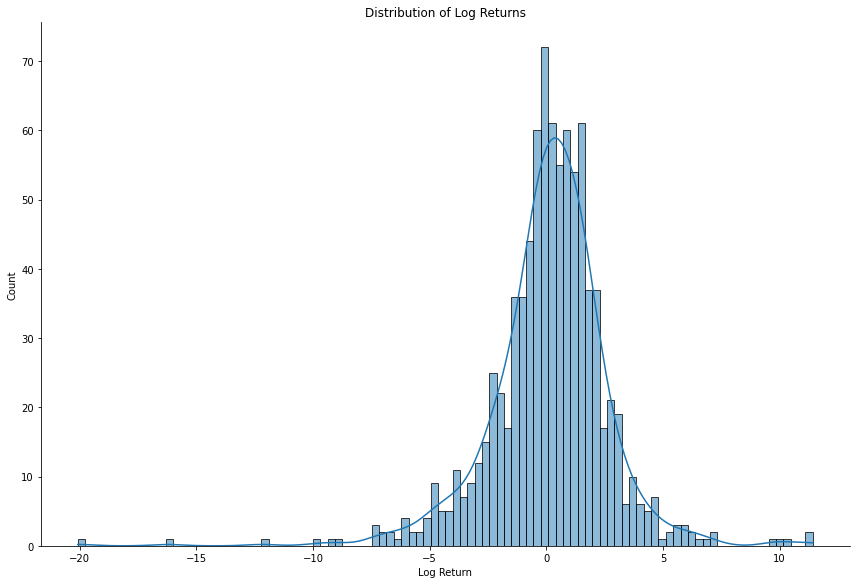


Descriptive statistics for Log Returns:
count    887.000000
mean       0.124833
std        2.563441
min      -20.083751
25%       -0.985532
50%        0.269669
75%        1.481964
max       11.423675
Name: Log Return, dtype: float64

Skewness (Log Returns):  -0.9555603534895724
Kurtosis (Log Returns):  8.240317958221539


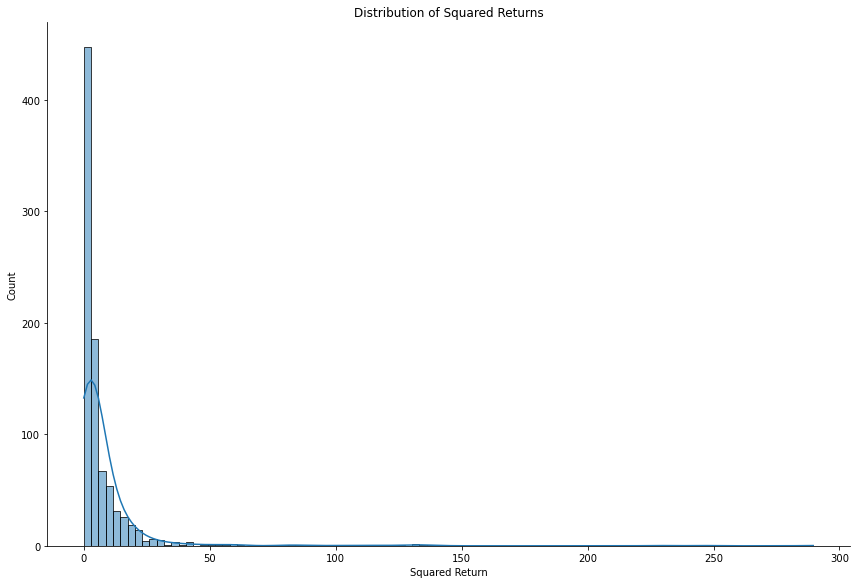


Descriptive statistics for Squared Returns:
count    887.000000
mean       7.819285
std       20.369962
min        0.033871
25%        1.108428
50%        2.901611
75%        6.994919
max      289.535432
Name: Squared Return, dtype: float64

Skewness (Squared Returns):  8.202371222206468
Kurtosis (Squared Returns):  85.36982273211757


In [295]:
# Function to plot distribution, describe statistics, and calculate skewness and kurtosis
def analyze_return_distribution(series, title):
    sns.displot(series.dropna(), bins=100, kde=True, height=8, aspect=1.5)
    plt.title(f'Distribution of {title}')
    plt.show()

    # Descriptive statistics for the returns
    print(f'\nDescriptive statistics for {title}:')
    print(series.describe())

    # Skewness and kurtosis for returns
    print(f'\nSkewness ({title}): ', skew(series.dropna()))
    print(f'Kurtosis ({title}): ', kurtosis(series.dropna()))

# Assuming you have a dataframe named sp500 with columns 'Log Return' and 'Squared Return'
analyze_return_distribution(sp500['Log Return'], 'Log Returns')
analyze_return_distribution(sp500['Squared Return'], 'Squared Returns')

In [296]:
# Find the date of highest squared return in sp500
sp500.sort_values(ascending=False, by='Squared Return')


,Date,Log Return,Squared Return,YearMonth,RV
740,2020-03-15,-9.203470,289.535432,2020-03,776.217039
741,2020-03-22,-16.227902,245.049951,2020-03,776.217039
145,2008-10-19,4.493711,227.734586,2008-10,560.384344
742,2020-03-29,9.769671,138.984228,2020-03,776.217039
150,2008-11-23,-8.761840,133.507925,2008-11,489.653814
...,...,...,...,...,...
412,2013-12-01,0.058165,0.083986,2013-12,7.333245
693,2019-04-21,-0.081889,0.083273,2019-04,3.698587
371,2013-02-17,0.122459,0.048290,2013-02,7.590694
260,2011-01-02,0.069201,0.043016,2011-01,8.126404


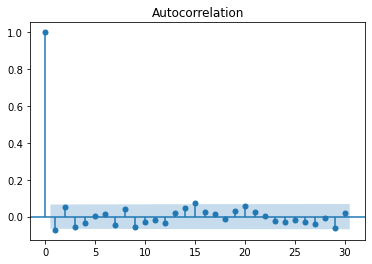

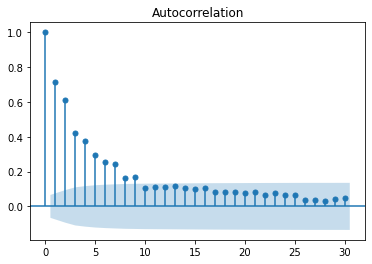

In [297]:
# Plot the autocorrelation of the returns
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sp500['Log Return'].dropna())
plt.show()

# Now, plot the autocorrelation of squared returns

plot_acf(sp500['Squared Return'].dropna())
plt.show()

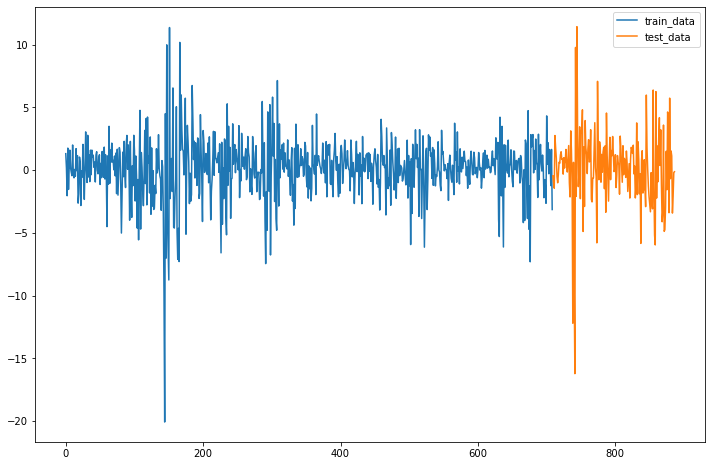

In [298]:

# Split the data into 80% train and 20% test
split = int(len(sp500_returns) * 0.8)
train, test = sp500_returns[:split], sp500_returns[split:]

# Plot the train_data, val_data and test_data sets
plt.figure(figsize=(12, 8))
plt.plot(train['Log Return'], label='train_data')
plt.plot(test['Log Return'], label='test_data')
plt.legend()
plt.show()

In [299]:
# Perform an ADF test on the data
adf_result = adfuller(sp500['Log Return'].dropna())

# adf test value and p-value
adf, p_value, *_ = adf_result

# Print out adf and its p-value
print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')

ADF Statistic: -17.833380608448792
p-value: 3.1268528824458308e-30


### VIsualizing low frequency data

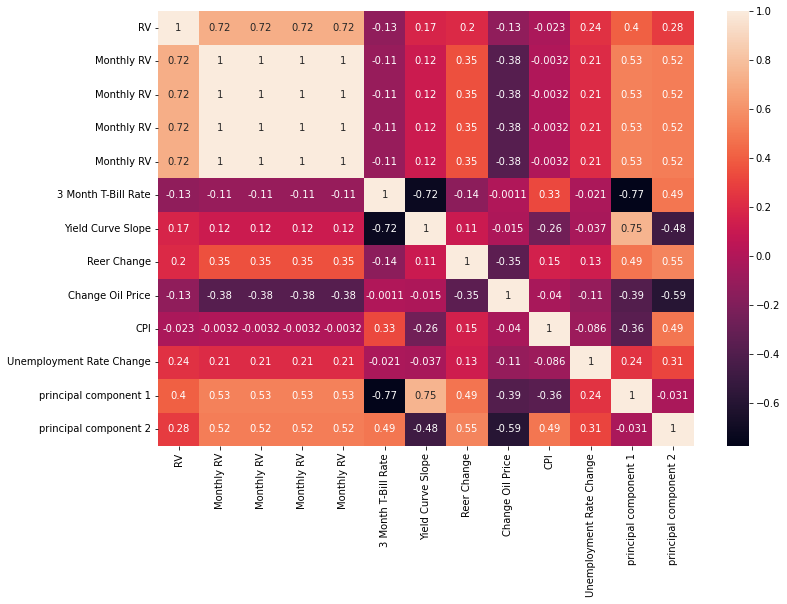

In [300]:
visualization_df = merged_df[features + ['principal component 1', 'principal component 2', 'YearMonth', 'RV', 'Monthly RV']]

# Take only one row of each YearMonth
visualization_df = visualization_df.groupby('YearMonth').first()

# Visualize the correlation, make RV the first column row
visualization_df = visualization_df[['RV', 'Monthly RV'] + features + ['principal component 1', 'principal component 2']]
visualization_df

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(visualization_df.corr(), annot=True)
plt.show()

# Define the data to be used in the models

In [301]:
return_data = merged_df['Log Return']
volatility_data = merged_df['RV']

test_size =  int(0.2 * len(return_data))

In [302]:
# Create a GARCH(1, 1) model, first train it on train data, then test on test data

garch11_model = arch_model(return_data[:-test_size], p=1, q=1)
garch11_model_fit = garch11_model.fit()
garch11_model_fit.summary()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 134320321506.25578
Iteration:      2,   Func. Count:     14,   Neg. LLF: 409289773.47437996
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1655.5686448643842
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1529.839554045603
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1492.6752684299809
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1491.4444386547325
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1491.1613332601223
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1491.1605558187912
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1491.1605469510337
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1491.1605464394443
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1491.1605464394443
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1491.16
Distribution:                  Normal   AIC:                           2990.32
Method:            Maximum Likelihood   BIC:                           3008.58
                                        No. Observations:                  710
Date:                Wed, Nov 08 2023   Df Residuals:                      709
Time:                        15:12:17   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2785  6.420e-02      4.337  1.444e-05 [  0.153,  0.404]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3768      0.127      2.972  2.962e-03 [  0.128,  0.625]
alpha[1]       0.2819  7.246e-02      3.891  9.988e-05 [  0.140,  0.424]
beta[1]        0.6649  6.559e-02     10.138  3.750e-24 [  0.536,  0.793]
========================================================================

Covariance estimator: robust
"""

# Create a simple fixed parameter GARCH(1, 1) model for comparison purposes

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4055.291946249725
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30013681712.012627
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1827.9856485286357
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1641.7966039892433
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1466.9050886955588
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1455.975923885077
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1455.9006461065667
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1455.8832712709232
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1455.8807279145217
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1455.8806675831456
Iteration:     11,   Func. Count:     68,   Neg. LLF: 1455.880658371327
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1455.8806570406314
Iteration:     13,   Func. Count:     77,   Neg. LLF: 1455.8806570404643
Optimization terminated successfully    (Exit mode 0)


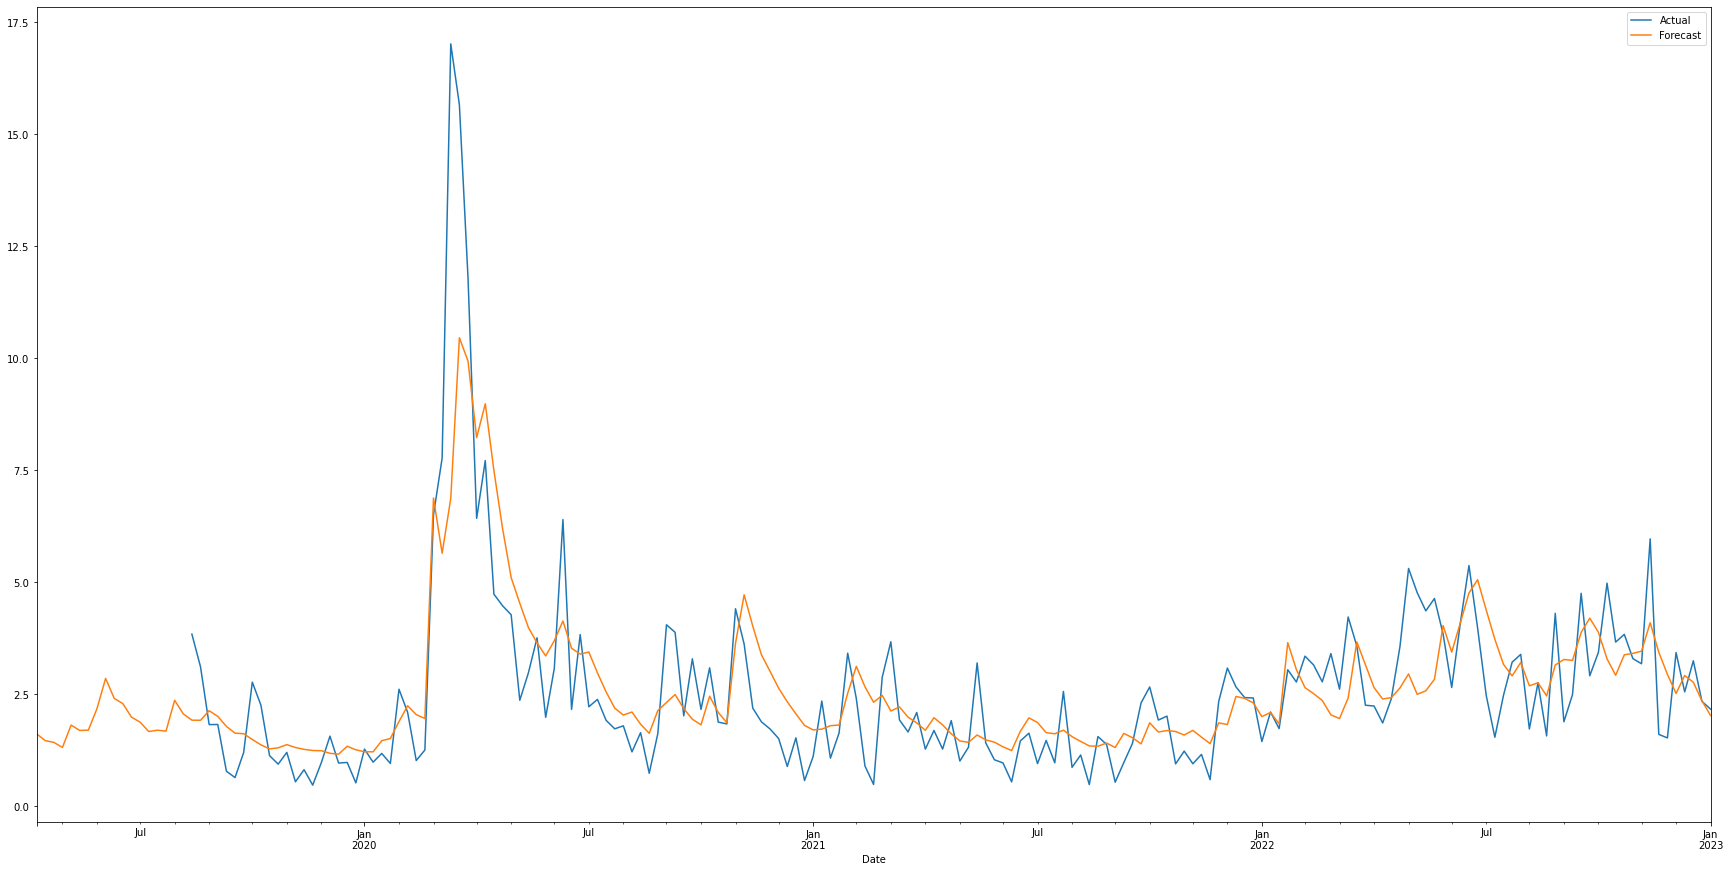

In [303]:
fixed_garch11 = arch_model(return_data, p=1, q=1)

res = fixed_garch11.fit(last_obs=693, update_freq=1)
forecasts_fixed_garch11 = res.forecast(horizon=1)
forecast_df = forecasts_fixed_garch11.variance
vol_df = pd.DataFrame(volatility_data[-test_size:])
combined_data = pd.concat([vol_df, np.sqrt(forecast_df)], axis=1)

combined_data.columns = ['Actual', 'Forecast']

# Plot the data
combined_data.plot(figsize=(30, 15))
plt.show()

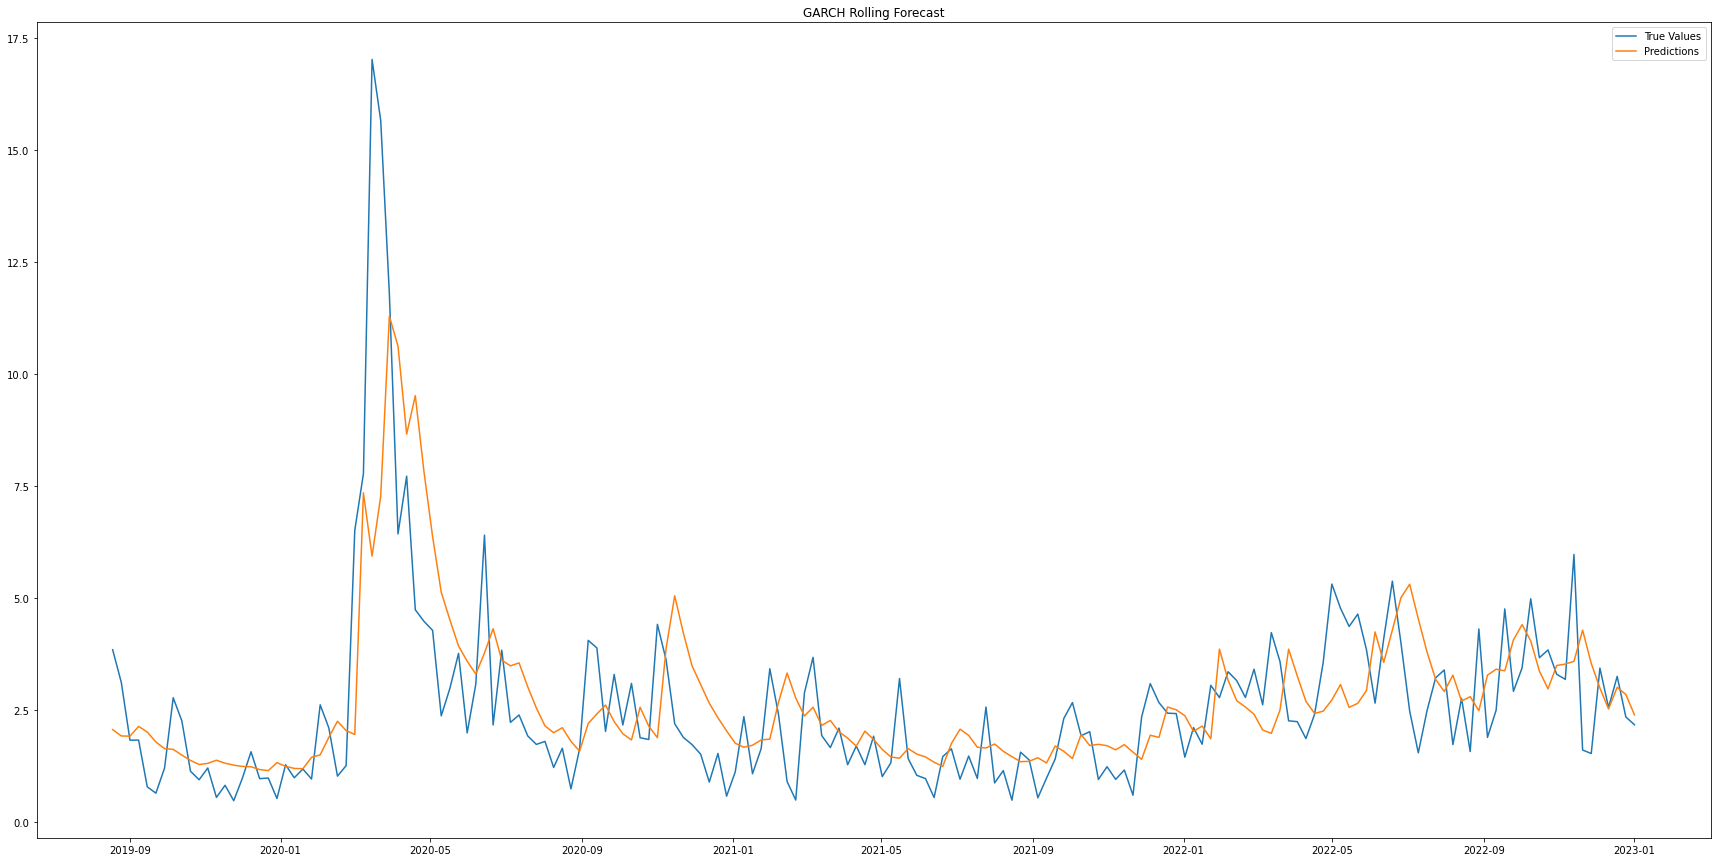

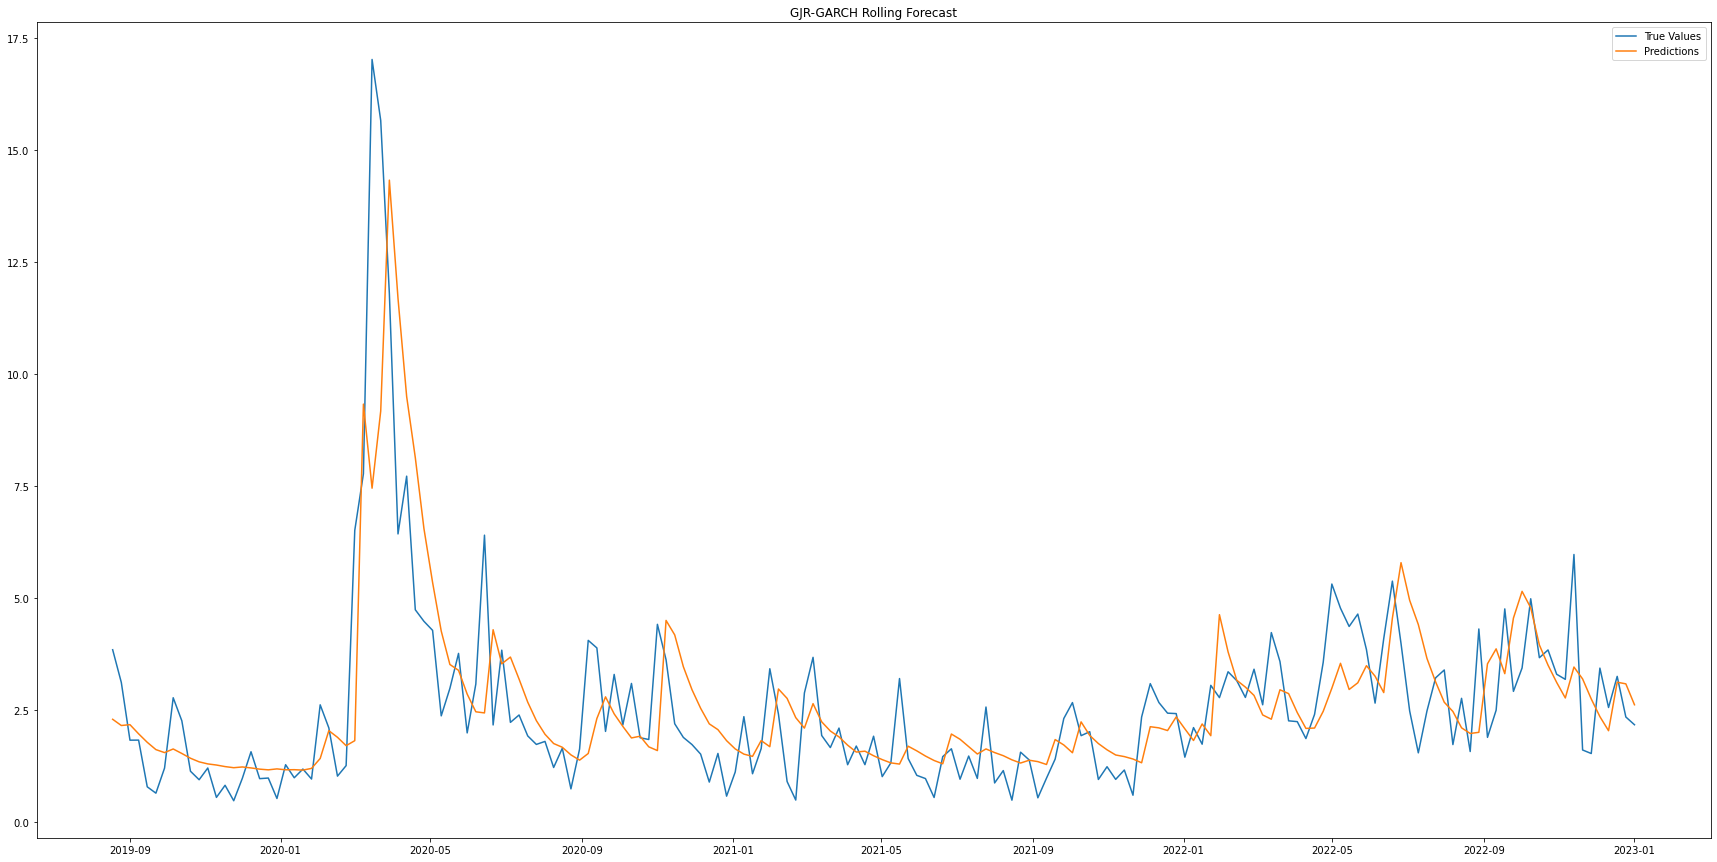

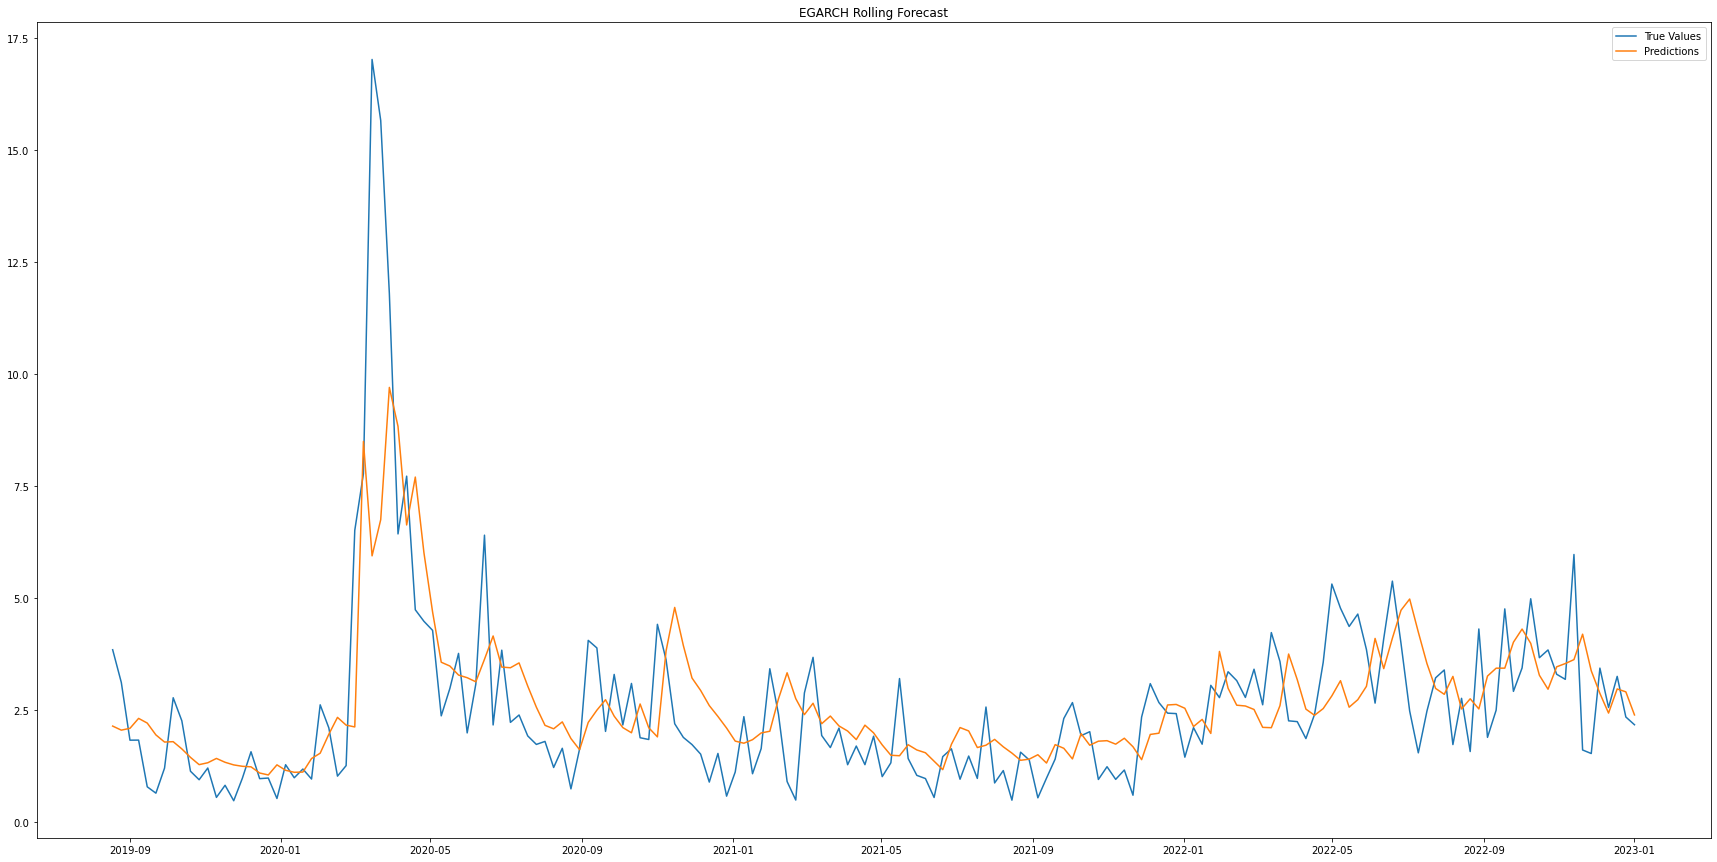

In [304]:
# Define a function to perform rolling forecast with different GARCH models
def rolling_garch_forecast(data, test_size, garch_type='GARCH', p=1, o=0, q=1):
    rolling_predictions = []
    
    for i in range(test_size):
        train = data[:-(test_size-i)]
        if garch_type == 'GARCH':
            model = arch_model(train, p=p, q=q)
        elif garch_type == 'GJR-GARCH':
            model = arch_model(train, p=p, o=1, q=q)
        elif garch_type == 'EGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='EGARCH')
        elif garch_type == 'FIGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='FIGARCH')
        else:
            raise ValueError("Unsupported GARCH model type")
        
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(pred.variance.values[-1,:][0])
    
    rolling_predictions = pd.Series(rolling_predictions, index=data.index[-test_size:])
    return np.sqrt(rolling_predictions)

# Function to plot the results
def plot_rolling_forecast(true_data, predicted_data, title):
    plt.figure(figsize=(12, 8))
    true, = plt.plot(true_data, label='True Values')
    preds, = plt.plot(predicted_data, label='Predictions')
    plt.title(title)
    plt.legend(handles=[true, preds])
    plt.show()

def plot_volatility(true_data, predicted_data, title):
    plt.figure(figsize=(30, 15))
    true, = plt.plot(true_data)
    preds, = plt.plot(predicted_data)
    plt.title(title)
    plt.legend(['True Values', 'Predictions'])
    plt.show()

garch11_predictions = rolling_garch_forecast(return_data, test_size, 'GARCH')
gjr_garch_predictions = rolling_garch_forecast(return_data, test_size, 'GJR-GARCH')
egarch_predictions = rolling_garch_forecast(return_data, test_size, 'EGARCH')
figarch_predictions = rolling_garch_forecast(return_data, test_size, 'FIGARCH')

# Plotting the results
plot_volatility(volatility_data[-test_size:], garch11_predictions, 'GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], gjr_garch_predictions, 'GJR-GARCH Rolling Forecast')
plot_volatility(volatility_data[-test_size:], egarch_predictions, 'EGARCH Rolling Forecast')

# RNGARCH

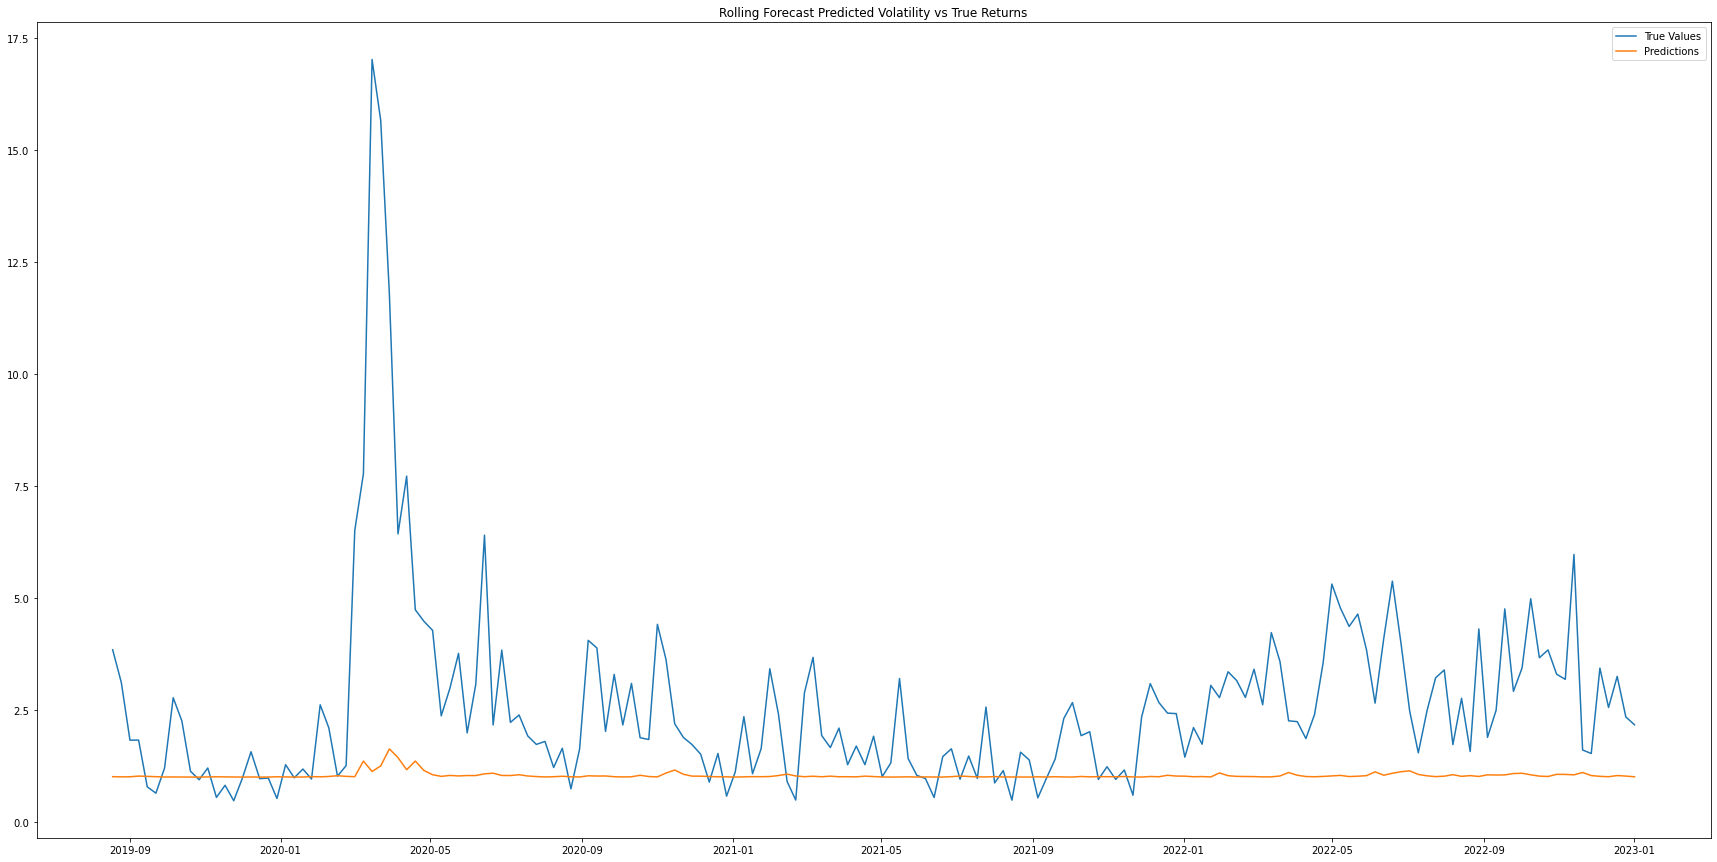

In [305]:
def garch_forecast(omega, alpha, beta, r):
    iT = len(r)
    variance = np.zeros(iT)

    for i in range(iT):
        if i == 0:
            # set initial value to long run variance
            variance[i] = omega / (1 - alpha - beta)
        else:
            # standard GARCH(1,1) recursion
            variance[i] = omega + alpha * r[i - 1] ** 2 + beta * variance[i - 1]

    return np.sqrt(variance)

# Random number generate omega, alpha, beta so that they sum up to one
omega, alpha, beta = [np.random.rand() for _i in range(3)]
standardizer_value = sum([omega, alpha, beta])

# Make sure they sum up to one
omega = omega / (standardizer_value)
alpha = alpha / (standardizer_value)
beta = beta / (standardizer_value)

forecasts = garch_forecast(omega, alpha, beta, r=return_data)

# Turn the numpy array to series
rngarch_predictions = pd.Series(forecasts, index=return_data.index)

plt.figure(figsize=(30,15))
true, = plt.plot(volatility_data[-test_size:])
preds, = plt.plot(rngarch_predictions[-test_size:])
plt.title('Rolling Forecast Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])


## Performance Metrics

In [306]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Define your efficiency metrics functions here
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def rmspe(actual, predicted):
    return np.sqrt(np.mean(np.square((actual - predicted) / actual)))

def mda(actual, predicted):
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])
        ).astype(int)
    )

def r_squared(actual, predicted):
    # Need to add a constant to use OLS
    predicted = sm.add_constant(predicted)
    model = sm.OLS(actual, predicted)
    results = model.fit()
    return results.rsquared

# Define the model efficiency function
def model_efficiency(actual, predicted, title):
    return pd.DataFrame(
        {
            "MAPE": mape(actual, predicted),
            "RMSPE": rmspe(actual, predicted),
            "MDA": mda(actual, predicted),
            "R^2": r_squared(actual, predicted),
        },
        index=[title],
    )

actual_volatility = volatility_data[-test_size:].values

# Create a dictionary mapping model names to their predictions
model_predictions = {
    'GARCH(1,1)-FIXED': forecasts_fixed_garch11.variance,
    'GARCH(1,1)': garch11_predictions,
    'GJR-GARCH': gjr_garch_predictions,
    'EGARCH': egarch_predictions,
    'RNGARCH': rngarch_predictions
}

# Initialize an empty DataFrame to store efficiency metrics for all models
all_model_efficiency = pd.DataFrame()

# Loop over the dictionary and compute efficiency metrics
for model_name, predictions in model_predictions.items():
    # Compute the efficiency metrics for the current model
    efficiency = model_efficiency(actual_volatility, predictions[-test_size:].values, model_name)
    
    # Append the efficiency DataFrame to the all_model_efficiency DataFrame
    all_model_efficiency = pd.concat([all_model_efficiency, efficiency])

# Display the efficiency metrics for all models
print(all_model_efficiency)


                      MAPE      RMSPE       MDA       R^2
GARCH(1,1)-FIXED  4.772835  12.422176  0.536415  0.638831
GARCH(1,1)        0.526627   0.793003  0.653409  0.424493
GJR-GARCH         0.449139   0.658592  0.710227  0.537574
EGARCH            0.523096   0.793674  0.664773  0.467884
RNGARCH           0.512035   0.572119  0.647727  0.360064


In [307]:
r_predictions = pd.read_csv('data/out_of_sample.csv', index_col=0)

# Loop over each model in the dataframe, and compute the efficiency metrics for each model
for model_name in r_predictions.columns:
    # Compute the efficiency metrics for the current model
    efficiency = model_efficiency(actual_volatility, r_predictions[model_name].values, f'R-{model_name}')
    
    # Append the efficiency DataFrame to the all_model_efficiency DataFrame
    all_model_efficiency = pd.concat([all_model_efficiency, efficiency])

print(round(all_model_efficiency, 3))

ValueError: operands could not be broadcast together with shapes (177,) (173,) 

In [ ]:
gjr_garch_predictions

Date
2019-04-14    1.544432
2019-04-21    1.428875
2019-04-28    1.350720
2019-05-05    1.299007
2019-05-12    1.245467
                ...   
2022-07-03    4.941685
2022-07-10    4.402250
2022-07-17    3.645659
2022-07-24    3.122661
2022-07-31    2.667744
Length: 173, dtype: float64